# Policy Exploration vs Varying Gamma Value 

In [1]:
import os
import pandas as pd

file_list = []

for txt_file in os.listdir('./txt_files/'):
    if txt_file.startswith('gamma_'):
        file_list.append(txt_file)
        
print file_list[0]

gamma_0.5_epsilon_0.5_ep_decay_0.99_number_of_times_10.txt


In [2]:
# parse the text to find out how reward improves
def parse_text(txt_file):
    with open(txt_file) as f: 
        content = f.readlines()
        
         #data to track
        columns_to_track = ['Trial', 'Gamma', 'Epsilon', 'Epsilon Decay','Start Location', 'Desination', 'Deadline', 
                            'Num -1 Rewards', 'Num 0.5 Rewards', 'Num 1 Rewards', 'Num 2 Rewards', 'Total Reward', 'Successful?']
        dframe = pd.DataFrame(columns=columns_to_track) #create empty dataframe

        #build one row of a time looking for columns to track data
        row = []
        main_trial = 0
        for line in content:
            # first line of the txt file 
            if 'Gamma:' in line:
                line_list = line.split(' ') #split on space
                gamma = float(line_list[1][:-1]) # get the gamma value
                epsilon = line_list[3][:-1] # get the epsilon value
                epsilon_decay = line_list[-1].strip() # get the epsilon decay value
                main_trial += 1 # increment main trail (1.1, 1.2....2.1, 2.2.....etc.)
            
            # the start of a new trial 
            if 'Simulator.run()' in line:
                net_reward = 0.0 # reset net reward 
                
                #keep track of number of rewards 
                num_reward_neg_1 = 0
                num_reward_point_5 = 0
                num_reward_1 = 0
                num_reward_2 = 0
                
                trial = line[16:].strip() # get trial number
                row.append(trial[:6] + str(main_trial) + '.' + trial[6:]) # splice in main trial
                row.append(gamma)
                row.append(epsilon)
                row.append(epsilon_decay)
                
            # environment initialization 
            if 'Environment.reset(): Trial set' in line:
                row.append(line[47:53].strip()) # get Start location
                row.append(line[69:75].strip()) # get distination
                row.append(int(line[88:91].strip())) # get Deadline
                
            # reward tracking
            if 'reward = -1' in line: num_reward_neg_1 += 1
            if 'reward = 0.5' in line: num_reward_point_5 += 1
            if 'reward = 1' in line: num_reward_1 += 1
            if 'reward = 2' in line: num_reward_2 += 1
                
            # net reward update 
            if 'Net Reward' in line:
                split_line = line.split(',')
                net_reward = float(split_line[0][11:])
              
            # successful or not successful
            if 'Environment.act()' in line or 'Environment.reset(): Primary' in line:
                row.append(num_reward_neg_1)
                row.append(num_reward_point_5)
                row.append(num_reward_1)
                row.append(num_reward_2)
                row.append(net_reward)
                if 'could not' in line:
                    row.append('No') #Not successful
                else:
                    row.append('Yes') #Successful
                #put in dataframe
                dframe = dframe.append(pd.Series(row, index=columns_to_track), ignore_index=True)
                row = [] #delete row data and start again
            
        return dframe

In [3]:
root_folder = './txt_files/'
dframe_dict = {}

for index, txt_file in enumerate(file_list):
    dframe_dict[index] = parse_text(root_folder + txt_file)
    
dframe_dict[0].head()    

,Trial,Gamma,Epsilon,Epsilon Decay,Start Location,Desination,Deadline,Num -1 Rewards,Num 0.5 Rewards,Num 1 Rewards,Num 2 Rewards,Total Reward,Successful?
0,Trial 1.0,0.5,0.5,0.99,"(6, 5)","(3, 3)",25.0,6.0,9.0,3.0,8.0,17.5,No
1,Trial 1.1,0.5,0.5,0.99,"(3, 3)","(7, 3)",20.0,3.0,10.0,1.0,7.0,17.0,No
2,Trial 1.2,0.5,0.5,0.99,"(4, 3)","(2, 6)",25.0,1.0,3.0,1.0,13.0,27.5,Yes
3,Trial 1.3,0.5,0.5,0.99,"(6, 1)","(5, 6)",30.0,0.0,1.0,0.0,2.0,4.5,Yes
4,Trial 1.4,0.5,0.5,0.99,"(2, 2)","(1, 5)",20.0,2.0,8.0,1.0,10.0,23.0,No


In [4]:
for key in dframe_dict:
    print 'Success Rate for index {}: {:.2f}%'.format(key,
        len(dframe_dict[key][dframe_dict[key]['Successful?'] == 'Yes']) / float(len(dframe_dict[key])) * 100)

Success Rate for index 0: 85.00%
Success Rate for index 1: 58.10%
Success Rate for index 2: 46.40%


In [5]:
#amplify the effects of reaching the destination within the alotted time
def add_if_successful(series, successes):
    new_series = series.copy(deep=True)
    for index, value in enumerate(series):
        if successes.iloc[index] == 'Yes':
            new_series.iloc[index] = value + 60       
    return new_series 

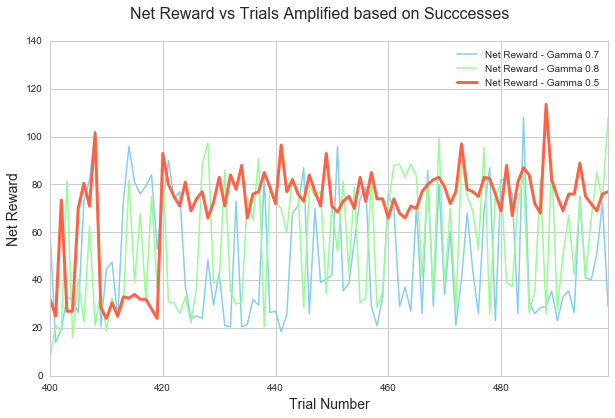

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
s = 400
e = 500

sns.set_style('whitegrid')

dframe_0_rewards = dframe_dict[0]['Total Reward'][s:e]
dframe_0_successes = dframe_dict[0]['Successful?'][s:e]
dframe_0_rewards_successes = add_if_successful(dframe_0_rewards, dframe_0_successes)

dframe_1_rewards = dframe_dict[1]['Total Reward'][s:e]
dframe_1_successes = dframe_dict[1]['Successful?'][s:e]
dframe_1_rewards_successes = add_if_successful(dframe_1_rewards, dframe_1_successes)

dframe_2_rewards = dframe_dict[2]['Total Reward'][s:e]
dframe_2_successes = dframe_dict[2]['Successful?'][s:e]
dframe_2_rewards_successes = add_if_successful(dframe_2_rewards, dframe_2_successes)

(dframe_1_rewards_successes).plot(c='skyblue', linewidth=1.5, label='Net Reward - Gamma 0.7')
(dframe_2_rewards_successes).plot(c='palegreen', linewidth=1.5, ylim=(0, 140), label='Net Reward - Gamma 0.8')
(dframe_0_rewards_successes).plot(c='tomato', linewidth=3, label='Net Reward - Gamma 0.5')
plt.suptitle('Net Reward vs Trials Amplified based on Succcesses', fontsize=16)
plt.xlabel('Trial Number', fontsize=14)
plt.ylabel('Net Reward', fontsize=14)
plt.legend()
plt.show()

(2, 13)

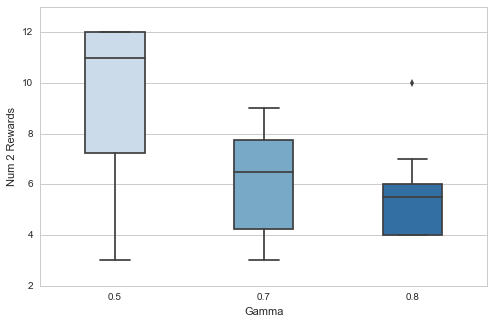

In [7]:
reward_columns = ['Gamma', 'Num -1 Rewards', 'Num 0.5 Rewards', 'Num 1 Rewards', 'Num 2 Rewards']
s = 290
e = 300

plt.figure(figsize=(8, 5))
rewards_frame = dframe_dict[0][reward_columns][s:e]
rewards_frame = rewards_frame.append(dframe_dict[1][reward_columns][s:e], ignore_index=True)
rewards_frame = rewards_frame.append(dframe_dict[2][reward_columns][s:e], ignore_index=True)

rewards_frame.head()
sns.boxplot(data=rewards_frame, x='Gamma', y='Num 2 Rewards', palette='Blues', width=0.4)
plt.ylim(2, 13)

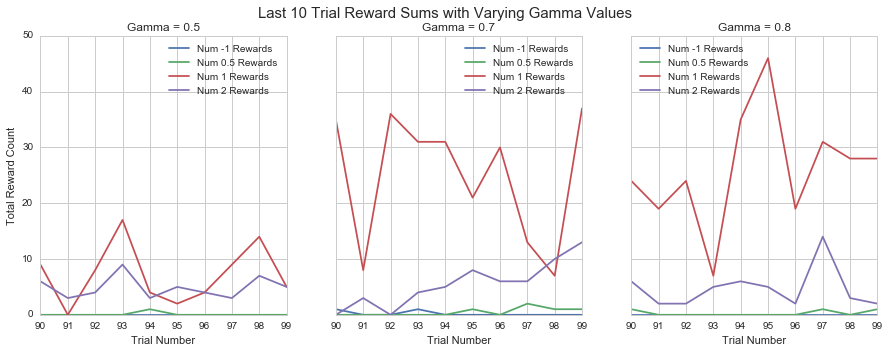

In [50]:
s = 190
e = 200

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(15,5))
f.suptitle('Last 10 Trial Reward Sums with Varying Gamma Values', fontsize=15)
labels = [i for i in range(90, 100, 1)]

dframe_dict[0][s:e][reward_columns[1:]].plot(ax=ax1)
dframe_dict[1][s:e][reward_columns[1:]].plot(ax=ax2)
dframe_dict[2][s:e][reward_columns[1:]].plot(ax=ax3)
ax1.set_title('Gamma = 0.5', fontsize=12)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Total Reward Count')
ax2.set_title('Gamma = 0.7', fontsize=12)
ax2.set_xticklabels(labels)
ax2.set_xlabel('Trial Number')
ax3.set_title('Gamma = 0.8', fontsize=12)
ax3.set_xticklabels(labels)
ax3.set_xlabel('Trial Number')
plt.show()